In [1]:
import os
import pickle
import shutil
import re
import time
import math
import operator

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

from konlpy.tag import Mecab

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
USE_CUDA = torch.cuda.is_available()
#USE_CUDA = False
GPU_ID = 2

# 1. Preprocess Dataset

In [3]:
NUM_SYMBOL = 4

SOS_TOK = '<SOS>'
EOS_TOK = '<EOS>'
PAD_TOK = '<PAD>'
UNK_TOK = '<UNK>'

SOS_IDX = 0
EOS_IDX = 1
PAD_IDX = 2
UNK_IDX = 3

In [4]:
SRC_VOCAB_SIZE = 5000
TGT_VOCAB_SIZE = 5000

MAX_LENGTH = 20 + 1

In [5]:
SRC_FILENAME = 'dataset/korean_dialog/hangul_src.txt'
TGT_FILENAME = 'dataset/korean_dialog/hangul_tgt.txt'

In [6]:
class Data:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {
            SOS_IDX:SOS_TOK,
            EOS_IDX:EOS_TOK,
            PAD_IDX:PAD_TOK,
            UNK_IDX:UNK_TOK
        }
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def makeVocabDict(self, vocab_size):
        sorted_vocab = sorted(self.word2count.items(), key=operator.itemgetter(1), reverse=True)[:vocab_size]
        
        sorted_i2w = {i+NUM_SYMBOL:sorted_vocab[i][0] for i in range(vocab_size)}
        sorted_w2i = {sorted_vocab[i][0]:i for i in range(vocab_size)}
        
        self.index2word.update(sorted_i2w)
        self.word2index.update(sorted_w2i)
        
        self.n_words = vocab_size

In [7]:
def normalizeString(s):
    s = re.sub('[^가-힝0-9a-zA-Z\\s]', '', s)
    return s

In [8]:
def readData(src_fileName, tgt_fileName, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    src_lines = open(src_fileName, 'r', encoding='utf-8').readlines()
    tgt_lines = open(tgt_fileName, 'r', encoding='utf-8').readlines()
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(src_lines[i][:-1]), normalizeString(tgt_lines[i][:-1])] for i in range(len(src_lines))]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_data = Data()
        output_data = Data()
    else:
        input_data = Data()
        output_data = Data()

    print("Success!")
    
    return input_data, output_data, pairs

In [9]:
def filterPair(p):
    return len(p[0]) < MAX_LENGTH and \
        len(p[1]) < MAX_LENGTH

def filterPairs(pairs):
    tagger = Mecab()
    pairs = [[tagger.morphs(pair[0]), tagger.morphs(pair[1])] for pair in pairs]
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
def prepareData(src_fileName, tgt_fileName, reverse=False):
    input_data, output_data, pairs = readData(src_fileName, tgt_fileName)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_data.addSentence(pair[0])
        output_data.addSentence(pair[1])
        
    org_input_n_words = input_data.n_words
    org_output_n_words = output_data.n_words
        
    input_data.makeVocabDict(SRC_VOCAB_SIZE)
    output_data.makeVocabDict(TGT_VOCAB_SIZE)
    
    print("Num of reduced words :")
    print("- Input data  :", org_input_n_words - input_data.n_words)
    print("- Output data :", org_output_n_words - output_data.n_words)
    
    return input_data, output_data, pairs

In [11]:
def indexesFromSentence(data, sentence):
    return [data.word2index[word] if word in data.word2index else UNK_IDX for word in sentence]

In [12]:
def variableFromSentence(data, sentence):
    indexes = indexesFromSentence(data, sentence)
    indexes.append(EOS_IDX)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if USE_CUDA:
        return result.cuda(GPU_ID)
    else:
        return result

In [13]:
def variablesFromPair(pair):
    input_variable = variableFromSentence(input_data, pair[0])
    target_variable = variableFromSentence(output_data, pair[1])
    return (input_variable, target_variable)

In [14]:
input_data, output_data, pairs = prepareData(SRC_FILENAME, TGT_FILENAME)
random.shuffle(pairs)

Reading lines...
Success!
Read 92192 sentence pairs
Trimmed to 86453 sentence pairs
Counting words...
Num of reduced words :
- Input data  : 10019
- Output data : 9983


In [15]:
train_size = int(len(pairs)*0.8)
val_size = int(len(pairs)*0.1)
test_size = int(len(pairs)*0.1)

train_pairs = pairs[:train_size]
val_pairs = pairs[train_size:train_size+val_size]
test_pairs = pairs[train_size+val_size:]

# 3. Define Model

In [16]:
INPUT_SIZE = input_data.n_words  # Num of Words
HIDDEN_SIZE = 128  # Embedding Dimension
OUTPUT_SIZE = output_data.n_words

BATCH_SIZE = 128

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda(GPU_ID)
        else:
            return result

In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda(GPU_ID)
        else:
            return result

In [19]:
def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(GPU_ID) if USE_CUDA else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_IDX]]))
    decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

        loss += criterion(decoder_output, target_variable[di])
        if ni == EOS_IDX:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [20]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(train_pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [21]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [22]:
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [23]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH, beam_size = 5):
    input_variable = variableFromSentence(input_data, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(GPU_ID) if USE_CUDA else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

        
    decoder_hidden = encoder_hidden
    
    score_board = [[[SOS_IDX], 0]]  #  list of [[sequence] and score]
    
    # with beam search
    while len(score_board[0][0]) != max_length + 1:
        print(len(score_board[0][0]))
        
        # Select best one
        cur = score_board.pop(0)  # [[sequence], score]
        candidate = cur[0][-1]
        
        # Find beams
        decoder_input = Variable(torch.LongTensor([[candidate]]))
        decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input
        
        decoder_output, decoder_hidden = testDecoder(decoder_input, decoder_hidden)
        topVecs, topIdxs = decoder_output.data.topk(beam_size)
        
        for next, score in zip(topIdxs.tolist()[0], topVecs.tolist()[0]):
            # Append beams to score board
            score = score + cur[1]  # log softmax
            score_board.append([cur[0]+[next], score])
            
        score_board = sorted(score_board, key=operator.itemgetter(1), reverse=True)[:5]

    decoded_words = []
    
    for idx in score_board[0][0]:
        if idx == EOS_IDX:
            decoded_words.append(EOS_TOK)
            break
        else:
            decoded_words.append(output_data.index2word[idx])

    return decoded_words

In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(test_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [26]:
NUM_ITER = 100000

In [27]:
encoder = EncoderRNN(INPUT_SIZE, HIDDEN_SIZE)
decoder = DecoderRNN(HIDDEN_SIZE, OUTPUT_SIZE)
if USE_CUDA:
    encoder.cuda(GPU_ID)
    decoder.cuda(GPU_ID)

31m 57s (- 287m 34s) (10000 10%) 2.4060
52m 5s (- 208m 22s) (20000 20%) 2.5291
61m 2s (- 142m 26s) (30000 30%) 2.5604
70m 10s (- 105m 15s) (40000 40%) 2.5414
79m 24s (- 79m 24s) (50000 50%) 2.6252
88m 50s (- 59m 13s) (60000 60%) 2.6690
98m 13s (- 42m 5s) (70000 70%) 2.6787
107m 50s (- 26m 57s) (80000 80%) 2.6445
117m 34s (- 13m 3s) (90000 90%) 2.7256
128m 0s (- 0m 0s) (100000 100%) 2.7399


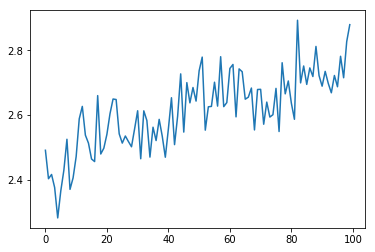

In [28]:
trainIters(encoder, decoder, NUM_ITER, print_every=NUM_ITER/10, plot_every=NUM_ITER/100, learning_rate=1e-3)

In [29]:
torch.save(encoder.state_dict(), 'otherdata.model')
torch.save(decoder.state_dict(), 'otherdata.model')

In [30]:
evaluateRandomly(encoder, decoder)

> ['체크인', '을', '하', '려고', '하', '는데요', '제', '이름', '은', '박정희', '입니다']
= ['잠시', '만', '기다리', '세요', '정희', '씨', '이번', '에', '환경', '보호', '프로그램', '세미나', '때문', '에', '오', '신', '거', '죠']
1


NameError: name 'testDecoder' is not defined

In [ ]:
for test_pair in test_pairs:
    print("input  : ", test_pair[0])
    print("output : ", evaluate(encoder, decoder, test_pair[0]))
    print()

In [ ]:
for i in range(5):
    input_sentence = input()
    print("output : ", evaluate(encoder, decoder, input_sentence))
    print()